# Encoders: Categorical Convolutional Example

Much like with the encoder examples for single transactions, we can also give the encoder categorical input (i.e. indexes) and ask it to predict a category rather than the binary output of the previous series example.

From a loss perspective we can also turn this into a __multi-label, multi-class__ problem, where we see each categorical field as a different label to predict. And then use regular CrossEntropy (LogMax + Negative-Log-Likelihood) over all the labels. Intuitively we might assume this might have an equalizing effect on the loss. The loss might be less dependent on the cardinality of the feature.


# Imports

In [1]:
import torch
import numpy as np
import gc
import datetime as dt

import d373c7.features as ft
import d373c7.engines as en
import d373c7.pytorch as pt
import d373c7.pytorch.models as pm
import d373c7.plot as pl

## Set a random seed for Numpy and Torch
> Will make sure we always sample in the same way. Makes it easier to compare results. At some point it should been removed to test the model stability.

In [2]:
# Numpy
np.random.seed(42)
# Torch
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## Define base feature and read the File
The base features are features found in the input file. They need to be defined after which the file can be read using the `EnginePandasNumpy`. Using the `from_csv` method.
The `from_csv` method will read the file and return a Pandas DataFrame object.

Clearly for this example we define the features as index features.

In [3]:
# Change this to read from another location
file = '../../../../data/bs140513_032310.csv'

In [4]:
step = ft.FeatureSource('step', ft.FEATURE_TYPE_INT_16) 
customer = ft.FeatureSource('customer', ft.FEATURE_TYPE_STRING)
age = ft.FeatureSource('age', ft.FEATURE_TYPE_CATEGORICAL)
gender = ft.FeatureSource('gender', ft.FEATURE_TYPE_CATEGORICAL)
merchant = ft.FeatureSource('merchant', ft.FEATURE_TYPE_CATEGORICAL)
category = ft.FeatureSource('category', ft.FEATURE_TYPE_CATEGORICAL)
amount = ft.FeatureSource('amount', ft.FEATURE_TYPE_FLOAT)
fraud = ft.FeatureSource('fraud', ft.FEATURE_TYPE_INT_8)

base_features = ft.TensorDefinition(
    'base', 
    [
        step,
        customer,
        age,
        gender,
        merchant,
        category,
        amount,
        fraud
    ])

amount_binned = ft.FeatureBin('amount_bin', ft.FEATURE_TYPE_INT_16, amount, 30)

# Function to calculate the date and time from the step
def step_to_date(step_count: int):
    return dt.datetime(2020, 1, 1) + dt.timedelta(days=int(step_count))

date_time = ft.FeatureExpression('date', ft.FEATURE_TYPE_DATE_TIME, step_to_date, [step])

intermediate_features = ft.TensorDefinition(
    'intermediate', 
    [
        customer,
        step,
        age,
        gender,
        merchant,
        category,
        amount,
        fraud
    ])

age_i = ft.FeatureIndex('age_index', ft.FEATURE_TYPE_INT_8, age)
gender_i = ft.FeatureIndex('gender_index', ft.FEATURE_TYPE_INT_8, gender)
merchant_i = ft.FeatureIndex('merchant_index', ft.FEATURE_TYPE_INT_16, merchant)
category_i = ft.FeatureIndex('category_index', ft.FEATURE_TYPE_INT_16, category)
fraud_label = ft.FeatureLabelBinary('fraud_label', fraud)


learning_features = ft.TensorDefinition(
    'learning', 
    [
        customer,
        date_time,
        age_i,
        gender_i,
        merchant_i,
        category_i,
        amount_binned
    ])

label = ft.TensorDefinition('label', [fraud_label])

model_features = ft.TensorDefinitionMulti([learning_features, label])

with en.EnginePandasNumpy(num_threads=8) as e:
    df = e.from_csv(base_features, file, inference=False)
    df = e.from_df(intermediate_features, df, inference=False)
    trx_df = e.from_df(learning_features, df, inference=False)
    lb_df = e.from_df(label, df, inference=False)
    ser_np = e.to_series_stacked(
        trx_df, learning_features, key_field=customer, time_field=date_time, length=5
    )
    lb_np = e.to_numpy_list(label, lb_df)
    data_list = en.NumpyList(ser_np.lists + lb_np.lists)

learning_features.remove(customer)
learning_features.remove(date_time)
    
print('Data Shapes')
print(data_list.shapes)
print(data_list.dtype_names)

2021-02-20 11:45:29.249 d373c7.engines.common          INFO     Start Engine...
2021-02-20 11:45:29.250 d373c7.engines.panda_numpy     INFO     Pandas Version : 1.1.4
2021-02-20 11:45:29.250 d373c7.engines.panda_numpy     INFO     Numpy Version : 1.19.2
2021-02-20 11:45:29.250 d373c7.engines.panda_numpy     INFO     Building Panda for : base from file ../../../../data/bs140513_032310.csv
2021-02-20 11:45:29.457 d373c7.engines.panda_numpy     INFO     Building Panda for : <base> from DataFrame. Inference mode <False>
2021-02-20 11:45:29.470 d373c7.engines.panda_numpy     INFO     Done creating base. Shape=(594643, 8)
2021-02-20 11:45:29.471 d373c7.engines.panda_numpy     INFO     Building Panda for : <intermediate> from DataFrame. Inference mode <False>
2021-02-20 11:45:29.482 d373c7.engines.panda_numpy     INFO     Done creating intermediate. Shape=(594643, 8)
2021-02-20 11:45:29.482 d373c7.engines.panda_numpy     INFO     Building Panda for : <learning> from DataFrame. Inference mode 

Data Shapes
[(594643, 5, 5), (594643,)]
['int16', 'int8']


## Wrangle the data
Time to split the data. For time series data it is very important to keep the order of the data. Below split will start from the end and work it's way to the front of the data. Doing so the training, validation and test data are nicely colocated in time. You almost *never* want to plain shuffle time based data.

> 1. Split out a test-set of size `test_records`. This is used for model testing.
> 2. Split out a validation-set of size `validation_records`. It will be used to monitor overfitting during training
> 3. All the rest is considered training data.

For time-series we'll perform an additional action.
> 1. The series at the beginning of the data set will all be more or less empty as there is no history, that is not so useful during training, ideally we have records with history and complete series, sometimes named 'mature' series. We'll throw away the first couple of entries.

__Important__; please make sure the data is ordered in ascending fashion on a date(time) field. The split function does not order the data, it assumes the data is in the correct order.

For auto-encoders we perform a 5th step, all fraud records will be removed from the training and validation data. The auto-encoder will only see *non-fraud* records during training.
> 1. Remove fraud records from training and validation


In [5]:
test_records = 100000
val_records  = 30000
maturation   = 30000

train_data, val_data, test_data = data_list.split_time(val_records, test_records) 
train_data = train_data[maturation:]

# Filter. Only keep non-fraud records with label 0. 
train_data = train_data.filter_label(model_features, 0)
val_data = val_data.filter_label(model_features, 0)

print(f'Training Data shapes {train_data.shapes}')
print(f'Validation Data shapes {val_data.shapes}')
print(f'Test Data shapes {test_data.shapes}')
del df, trx_df, lb_df, ser_np, lb_np, data_list
gc.collect()
print('Done')

Training Data shapes [(429311, 5, 5), (429311,)]
Validation Data shapes [(29670, 5, 5), (29670,)]
Test Data shapes [(100000, 5, 5), (100000,)]
Done


## Set-up Devices

In [6]:
device, cpu = pt.init_devices()

2021-02-20 11:45:35.316 d373c7.pytorch.common          INFO     Torch Version : 1.7.1+cu110
2021-02-20 11:45:35.344 d373c7.pytorch.common          INFO     GPU found. Using GPU <0>
2021-02-20 11:45:35.345 d373c7.pytorch.common          INFO     Cuda Version  : 11.0


## Build the model

> In this example we use a `GeneratedAutoEncoder` model. We're asking it to use 2 convolutional layers. The encoder layer reduces to __32 features/channels with a kernel_size of 2__, the second layer further reduces to __6 features/channels with a kernel_size of 1__. The decoder layer uses the exact same layers but reversed. This model is exactly defined in exactly the same as the binary example, because the model sees that we are using categorical features, it uses an embedding in the input and changes the ouput to match the input. The output in this case is a multi-label, multi-class series problem. Multi-label because the we are predicting each feature and multi class because there are multiple options per each label (the various feature values). And we do not just do this for a single payment, but for a series of payments.

In [8]:
# Setup Pytorch Datasets for the training and validation
batch_size = 128
train_ds = pt.NumpyListDataSetMulti(model_features, train_data)
val_ds = pt.NumpyListDataSetMulti(model_features, val_data)

# Wrap them in a Pytorch Dataloader
train_dl = train_ds.data_loader(cpu, batch_size, num_workers=2)
val_dl = val_ds.data_loader(cpu, batch_size, num_workers=2)

# Create a Model
m = pm.GeneratedAutoEncoder(model_features, convolutional_layers=[(32, 2), (6, 1)])

print(m)

GeneratedAutoEncoder(
  Number of parameters : 42201. Loss : NLLLoss(),mean
  (streams): ModuleList(
    (0): Sequential(
      (learning): TensorDefinitionHead(
        lcs=['Categorical']
        (embedding): Embedding(
          (embeddings): ModuleList(
            (0): Embedding(9, 4)
            (1): Embedding(5, 4)
            (2): Embedding(51, 25)
            (3): Embedding(16, 7)
            (4): Embedding(31, 15)
          )
          (dropout): Dropout(p=0.2, inplace=False)
        )
      )
      (encoder): ConvolutionalEncoder(
        (conv_layers): Sequential(
          (conv_01): Conv1d(55, 32, kernel_size=(2,), stride=(1,))
          (relu_01): ReLU()
          (conv_02): Conv1d(32, 6, kernel_size=(1,), stride=(1,))
        )
      )
      (decoder): ConvolutionalDecoder(
        (conv_layers): Sequential(
          (conv_01): ConvTranspose1d(6, 32, kernel_size=(1,), stride=(1,))
          (relu_01): ReLU()
          (conv_02): ConvTranspose1d(32, 112, kernel_size=(2,

Graphically that model looks like so. 

We split the encoder and decoder into to seperate depictions. 

#### Encoder
The encoder has the exact same output as the binary examples, the input is squeezed into a 6 (feature) x 4 (time steps) 2-D tensor. But other than the binary examples, this model receives 5 indexes (long numbers) as input. These indexes are each fed to an embedding layer. The output of the embeddings is concatenated and forms a 5 (timesteps) x 55 (output dims) 2-D tensor.

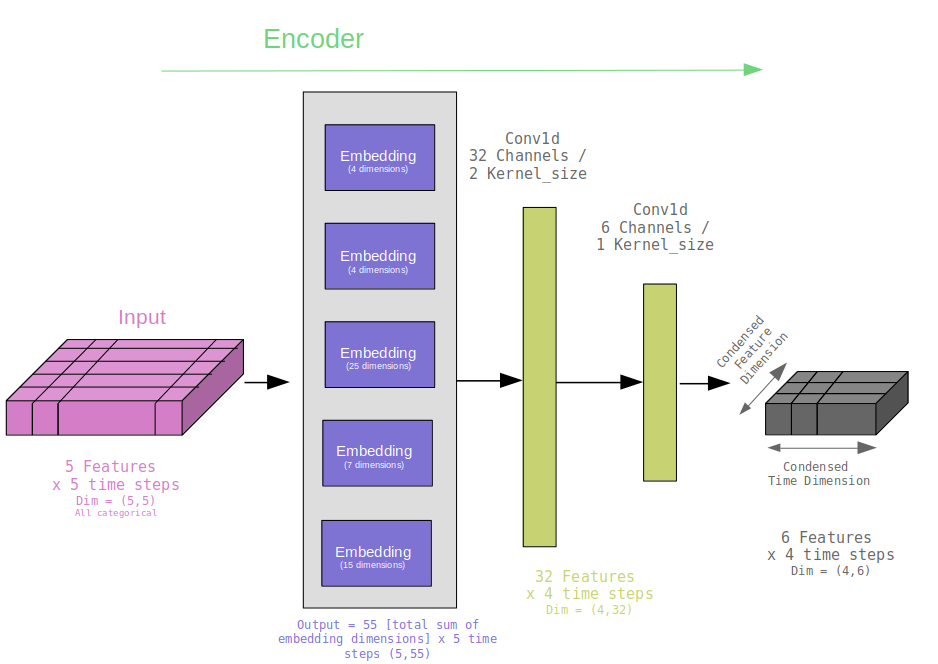

##### Decoder
The decoder takes the 2D latent tensor of 6 features and 4 time series dimension and runs it through 2 de-convolution layers. They expand the latent tensor back to a fairly complex 3D structure for each record. That structure has a 5 x 51 x 5 dimension. The last 5 are the number of labels, so our number of inputs, the 51 are the 'logit'-score for each of the 51 potential values. That means we have 5 labels which each can take 51 values, now not all of the categories have 51 potential values. But we take the maxiumum which is the value for the __merchant_i__ feature. This may look a bit like overhead, one might be tempted to think we should do make a 2D *logit* tensor per each class. That is possible, but rather slow, this construction allows us to calculate the *logit's* for all classes in one go. Which is much faster on GPU's.

For the loss we go a logsoftmax over the 2nd dimension and then reduce that dimension out using __nll__ (negative log likelihood) loss.

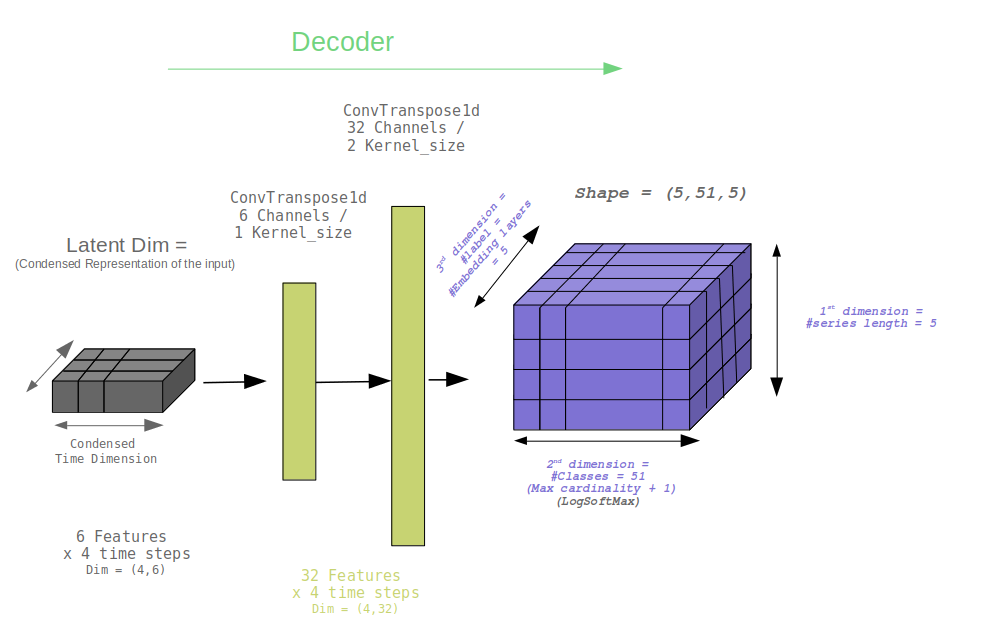

# Start Training

### First find a decent Learning Rate. 
> Create a trainer and run the find_lr function and plot. This functions iterates over the batches gradually increasing the learning rate from a minimum to a maximum learning rate.

2021-02-20 11:47:41.381 d373c7.pytorch.training        INFO     Saving model under ./temp_model.pt
Finding LR in 200 steps: 100%|██████████| 200/200 [00:00<00:00, 220.47it/s]
2021-02-20 11:47:43.555 d373c7.pytorch.training        INFO     Restoring model from ./temp_model.pt


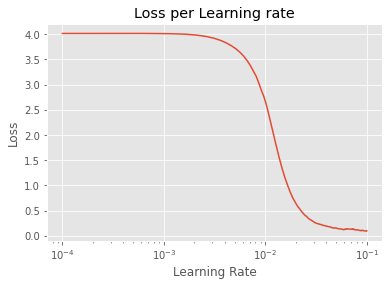

In [9]:
t = pt.Trainer(m, device, train_dl, val_dl)
r = t.find_lr(1e-4, 1e-1, 200)
pl.TrainPlot().plot_lr(r)

## Start Training and plot the results
> We train for __5 epochs__ and __learning rate 1e-2__. That means we run over the total training data set a total of 5 times/epochs where the model learns, after each epoch we use the trained model and perform a test run on the validation set.

Epoch 005/005: 100%|██████████| 3586/3586 [00:13<00:00, 257.94it/s, train_loss=0.0052, val_loss=0.0026]


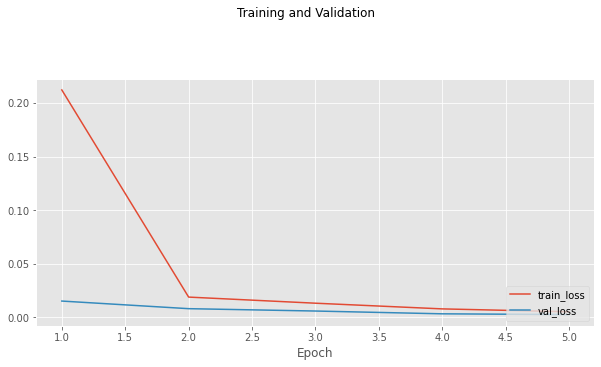

In [10]:
t = pt.Trainer(m, device, train_dl, val_dl)
h = t.train_one_cycle(5, 1e-2)
pl.TrainPlot().plot_history(h, fig_size=(10,10))

## Test the model on the test data
> The overall results are comparable to the binary to binary convolutional example. Though this model seems to be better at determining where the non-fraud is, whereas it's worse at finding the fraud as compared to the binary to binary example.

Creating Scores in 782 steps: 100%|██████████| 782/782 [00:00<00:00, 1020.39it/s]


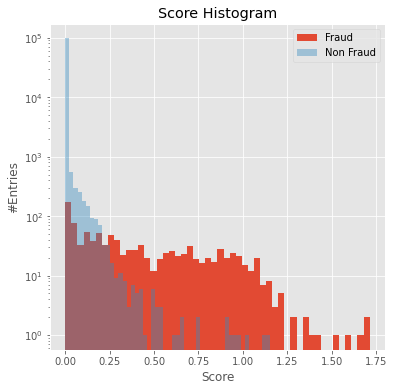

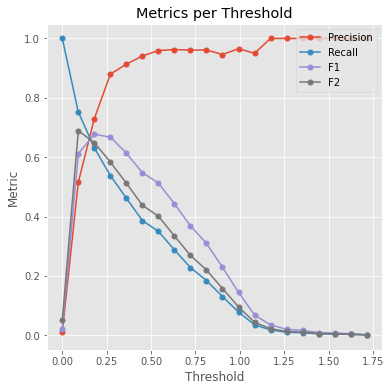

------------- Classification report -----------------
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     98926
         1.0       0.83      0.60      0.69      1074

    accuracy                           0.99    100000
   macro avg       0.91      0.80      0.84    100000
weighted avg       0.99      0.99      0.99    100000


auc score : 0.9925
ap score  : 0.7451
-----------------------------------------------------


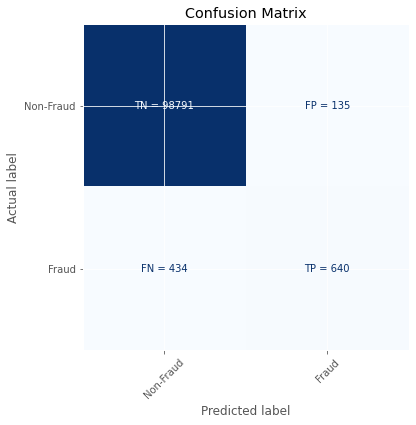

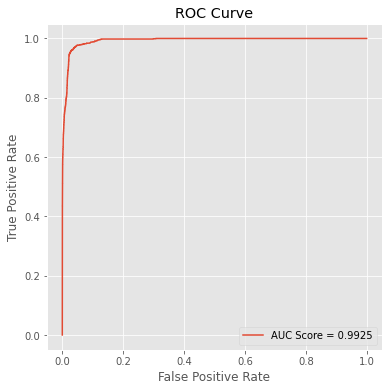

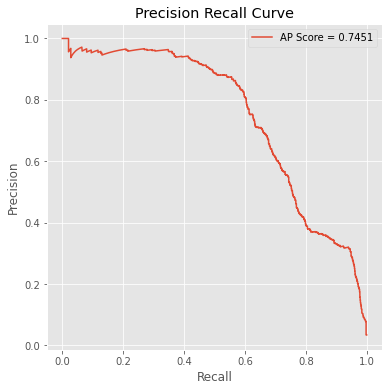

In [12]:
test_ds = pt.NumpyListDataSetMulti(model_features, test_data)
test_dl = test_ds.data_loader(cpu, 128, num_workers=2)

ts = pt.Tester(m, device, test_dl)
tp = pl.TestPlot()
r = ts.score_plot()
tp.plot_scores(r, 50, fig_size=(6,6))
tp.plot_score_metrics(r, 20, fig_size=(6,6))
tp.print_classification_report(r, threshold=0.22)
tp.plot_confusion_matrix(r, fig_size=(6,6), threshold=0.22)
tp.plot_roc_curve(r, fig_size=(6,6))
tp.plot_precision_recall_curve(r, fig_size=(6,6))

## Plot Embeddings
> Because we now created an embedding (Like in one of the classifier examples) we can visualize it. The plot_embedding method will take the `FeatureIndex` named __category_i__, PCA it and display the 3 principal components. 

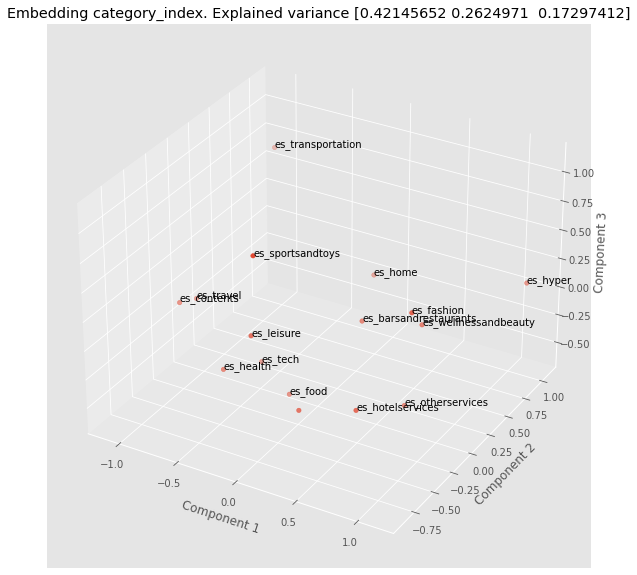

In [14]:
w = m.embedding_weight(category_i, True)
pl.LayerPlot().plot_embedding(category_i, w, dims=3, fig_size=(10,10))

# Conclusion
This was an example of a a convolutional encoder with categorical input and categorical (multi-label) output. As usual we can't read to much into this data, nevertheless; this models catches about 60% of the fraud with a very low false postive rate. Without ever having seen a fraud. 

If this were to hold true on real data and large scale, (this should not be taken for granted) it would mean that a low reconstruction loss implies the transaction was recognizable to the model, and that is unlikely to be fraud.